In [1]:
%%writefile ~/.theanorc
[global]
device=gpu
floatX=float32

[blas]
ldflags=-lopenblas

[cuda]
root=/opt/apps/cuda/7.0

[nvcc]
fastmath=True

Writing /home/02735/edwardk/.theanorc


In [3]:
%matplotlib inline

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import cPickle as pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import theano
import theano.tensor as T

import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.objectives import squared_error, categorical_crossentropy
from lasagne.nonlinearities import softmax
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator

In [5]:
X = np.load("/work/02735/edwardk/classify/data/training_images.npy", mmap_mode="r")
print("X.shape = {}, X.min = {}, X.max = {}".format(X.shape, X.min(), X.max()))

y = np.load("/work/02735/edwardk/classify/data/training_labels.npy")
print("y.shape = {}, y.min = {}, y.max = {}".format(y.shape, y.min(), y.max()))

X.shape = (100, 5, 48, 48), X.min = 15.2576580048, X.max = 25.4738693237
y.shape = (100,), y.min = -1.0, y.max = 1.0


In [6]:
def renormalize(array):
    return (array - array.min()) / (array.max() - array.min())

X, y = map(renormalize, (X, y))

print("X.shape = {}, X.min = {}, X.max = {}".format(X.shape, X.min(), X.max()))
print("y.shape = {}, y.min = {}, y.max = {}".format(y.shape, y.min(), y.max()))

X.shape = (100, 5, 48, 48), X.min = 0.0, X.max = 1.0
y.shape = (100,), y.min = 0.0, y.max = 1.0


In [7]:
def compute_PCA(array):

    nimages0, nchannels0, height0, width0 = array.shape
    rolled = np.transpose(array, (0, 2, 3, 1))
    # transpose from N x channels x height x width  to  N x height x width x channels
    nimages1, height1, width1, nchannels1 = rolled.shape
    # check shapes
    assert nimages0 == nimages1
    assert nchannels0 == nchannels1
    assert height0 == height1
    assert width0 == width1
    # flatten
    reshaped = rolled.reshape(nimages1 * height1 * width1, nchannels1)
    
    from sklearn.decomposition import PCA
    
    pca = PCA()
    pca.fit(reshaped)
    
    cov = pca.get_covariance()
    
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    
    return eigenvalues, eigenvectors

In [8]:
class AugmentedBatchIterator(BatchIterator):
    
    def __init__(self, batch_size, crop_size=8):
        super(AugmentedBatchIterator, self).__init__(batch_size)
        self.crop_size = crop_size

    def transform(self, Xb, yb):

        Xb, yb = super(AugmentedBatchIterator, self).transform(Xb, yb)
        batch_size, nchannels, width, height = Xb.shape
        
        eigenvalues, eigenvectors = compute_PCA(Xb)

        # Flip half of the images horizontally at random
        indices = np.random.choice(batch_size, batch_size // 2, replace=False)        
        Xb[indices] = Xb[indices, :, :, ::-1]

        # Crop images
        X_new = np.zeros(
            (batch_size, nchannels, width - self.crop_size, height - self.crop_size),
            dtype=np.float32
        )
        if yb is not None:
            y_new = yb.astype(np.int32)
        else:
            y_new = None

        for i in range(batch_size):
            # Choose x, y pixel posiitions at random
            px, py = np.random.choice(self.crop_size, size=2)
                
            sx = slice(px, px + width - self.crop_size)
            sy = slice(py, py + height - self.crop_size)
            
            # Rotate 0, 90, 180, or 270 degrees at random
            nrotate = np.random.choice(4)
            
            # add random color perturbation
            alpha = np.random.normal(loc=0.0, scale=0.5, size=5)
            noise = np.dot(eigenvectors, np.transpose(alpha * eigenvalues))
            
            for j in range(nchannels):
                X_new[i, j] = np.rot90(Xb[i, j, sx, sy] + noise[j], k=nrotate)
                
        return X_new, y_new

In [9]:
class SaveParams(object):
    def __init__(self, name):
        self.name = name

    def __call__(self, nn, train_history):
        if train_history[-1]["valid_loss_best"]:
            nn.save_params_to("{}.params".format(self.name))
            with open("{}.history".format(self.name), "w") as f:
                pickle.dump(train_history, f)

We set the `verbose` parameter to `2`.

# 4 dropout layer

In [12]:
net39 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),

        ('conv11', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),

        ('conv21', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),

        ('conv31', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),

        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        
        ('hidden5', layers.DenseLayer),

        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 5, 40, 40),
    
    conv11_num_filters=32, conv11_filter_size=(5, 5), 
    pool1_pool_size=(2, 2),
    dropout1_p=0.1,

    conv21_num_filters=64, conv21_filter_size=(3, 3),
    pool2_pool_size=(2, 2),
    dropout2_p=0.2,

    conv31_num_filters=128, conv31_filter_size=(3, 3),
    pool3_pool_size=(2, 2),
    dropout3_p=0.4,

    hidden4_num_units=2048,
    
    dropout4_p=0.5,
    hidden5_num_units=2048,

    output_num_units=2,
    output_nonlinearity=softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    objective_loss_function=categorical_crossentropy,
    regression=False,
    max_epochs=3000,
    batch_iterator_train=AugmentedBatchIterator(batch_size=128, crop_size=8),
    batch_iterator_test=AugmentedBatchIterator(batch_size=128, crop_size=8),

    on_epoch_finished=[SaveParams("net39")],

    verbose=2,
    )

In [13]:
net39.fit(X, y)

# Neural Network with 6658178 learnable parameters

## Layer information

name      size        total    cap.Y    cap.X    cov.Y    cov.X
--------  --------  -------  -------  -------  -------  -------
input     5x40x40      8000   100.00   100.00   100.00   100.00
conv11    32x36x36    41472   100.00   100.00    12.50    12.50
pool1     32x18x18    10368   100.00   100.00    12.50    12.50
dropout1  32x18x18    10368   100.00   100.00   100.00   100.00
conv21    64x16x16    16384   100.00   100.00   100.00   100.00
pool2     64x8x8       4096   100.00   100.00   100.00   100.00
dropout2  64x8x8       4096   100.00   100.00   100.00   100.00
conv31    128x6x6      4608   100.00   100.00   100.00   100.00
pool3     128x3x3      1152   100.00   100.00   100.00   100.00
dropout3  128x3x3      1152   100.00   100.00   100.00   100.00
hidden4   2048         2048   100.00   100.00   100.00   100.00
dropout4  2048         2048   100.00   100.00   100.00   100.00
hidden5   2048         2048   

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<__main__.AugmentedBatchIterator object at 0x2b6ee53c9b90>,
     batch_iterator_train=<__main__.AugmentedBatchIterator object at 0x2b6ec610a310>,
     conv11_filter_size=(5, 5), conv11_num_filters=32,
     conv21_filter_size=(3, 3), conv21_num_filters=64,
     conv31_filter_size=(3, 3), conv31_num_filters=128, custom_score=None,
     dropout1_p=0.1, dropout2_p=0.1, dropout3_p=0.5, dropout4_p=0.5,
     hidden4_num_units=2048, hidden5_num_units=2048,
     input_shape=(None, 5, 40, 40),
     layers=[(u'input', <class 'lasagne.layers.input.InputLayer'>), (u'conv11', <class 'lasagne.layers.conv.Conv2DLayer'>), (u'pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), (u'dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), (u'conv21', <class 'lasagne.layers.conv.Conv2DLayer'>), (u'pool... <class 'lasagne.layers.dense.DenseLayer'>), (u'output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=3000, more_params={

In [14]:
best_valid_loss = min([row['valid_loss'] for row in net39.train_history_])
print("Best valid loss: {}".format(best_valid_loss))

Best valid loss: 0.721799951262


In [15]:
net39.save_params_to("net39.params")

import cPickle as pickle
with open("net39.history", "wb") as f:
    pickle.dump(net39.train_history_, f, -1)

In [16]:
def plot_loss(net):
    train_loss = [row['train_loss'] for row in net.train_history_]
    valid_loss = [row['valid_loss'] for row in net.train_history_]
    plt.semilogy(train_loss, label='train loss')
    plt.semilogy(valid_loss, label='valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')

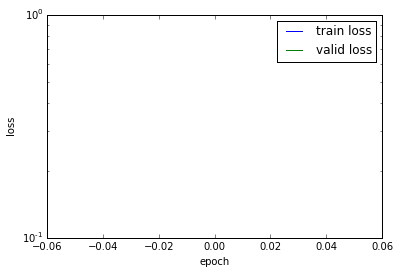

In [17]:
plot_loss(net39)

In [18]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y, net39.predict_proba(X)[:, 0]))

0.426091269841
